In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from cycler import cycler

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [6]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [7]:
sns.set()
plt.style.use("fivethirtyeight")
plt.rcParams['text.color'] = 'black'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'

In [8]:
colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c',
          '#aec7e8', '#69B0AC']
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

## Data Prep

### Read Synergy + CTG Data

In [9]:
s_df = pd.read_csv('nba_offense_plus_ctg.csv')
# s_df = s_df[s_df.Season != '2017-2018'].reset_index()\
#                                        .drop('index', axis=1)
s_df.shape

(3678, 65)

### Read BBR Data

In [10]:
bbr_df = pd.read_csv('bbr_nba_stats.csv')
# bbr_df = bbr_df[bbr_df.Season != '2017-2018'].reset_index()\
#                                              .drop('index', axis=1)

In [11]:
mp_filter = bbr_df['mp'] >= 300
bbr_df = bbr_df[mp_filter]
bbr_df.shape

(2576, 39)

In [12]:
bbr_df['mp'].min()

300

### Merge Synergy Data & BBR Data

In [13]:
s_df['Player_Alt'] = s_df['Player'].apply(lambda x: x.replace(' ', '').lower())\
                                   .apply(lambda x: x.replace("'", ''))\
                                   .apply(lambda x: x.replace('.', ''))

In [14]:
bbr_df['player_alt_alt'] = bbr_df['player_alt'].apply(lambda x: x.replace(' ', ''))\
                                               .apply(lambda x: x.replace("'", ''))\
                                               .apply(lambda x: x.replace('.', ''))\
                                               .apply(lambda x: x.lower())

In [15]:
synergy_name_dict = {'kevinknoxii': 'kevinknox',
                     'danilogalinari': 'danilogallinari',
                     'louiswilliams': 'louwilliams',
                     'eneskanter': 'enesfreedom',
                     'terryrozieriii': 'terryrozier',
                     'cameronreddish': 'camreddish',
                     'jahilokafor': 'jahlilokafor',
                     'danuelhouse': 'danuelhousejr',
                     'alfarouqaminu': 'al-farouqaminu',
                     'nenehilario': 'nene',
                     'frankmason': 'frankmasoniii',
                     'larrynance': 'larrynancejr',
                     'wesleyiwundu': 'wesiwundu',
                     'robertwilliamsiii': 'robertwilliams',
                     'harrygilesiii': 'harrygiles',
                     'jamesennis': 'jamesennisiii',
                     'mohamedbamba': 'mobamba',
                     'xaviertillman': 'xaviertillmansr',
                     'patrickbeverly': 'patrickbeverley',
                     'malcomdelaney': 'malcolmdelaney',
                     'marcusmorrissr': 'marcusmorris',
                     'nicolasclaxton': 'nicclaxton',
                     'juanhernangomez': 'juanchohernangomez',
                     'guillermohernangomez': 'willyhernangomez',
                     'timothéluwawu-cabarrot': 'timotheluwawu-cabarrot',
                     'nahshonhyland': 'boneshyland',
                     'derrickwaltonjr': 'derrickwalton',
                     'ishmailwainright': 'ishwainright',
                     'johnnyobryantiii': 'johnnyobryant'}

In [16]:
s_df['Player_Alt'] = s_df['Player_Alt']\
                     .apply(lambda x: synergy_name_dict.get(x, x))

In [17]:
df = s_df.merge(bbr_df, how='right', 
                left_on=['Player_Alt', 'Team', 'Season'],
                right_on=['player_alt_alt', 'team', 'Season'])
df = df[~df['player_alt_alt'].isna()].reset_index().drop('index', axis=1)
df.shape

(2577, 105)

In [18]:
# Fix Gerald Green Rockets 18-19
conds = ((df['Player'] == 'Gerald Green') & 
         (df['Season'] == '2018-2019') &
         (df['GP'] == 2))
df = df[~conds].reset_index(drop=True)
df.shape

(2576, 105)

In [19]:
# check 
df[['Player_Alt', 'Team', 'Season']].drop_duplicates().shape

(2576, 3)

## Clustering

### Functions

In [20]:
def plot_pca_explained_var(x):
    ev_list = []
    c_list = list(range(2, 12))
    for c in c_list:
        pca = PCA(n_components=c)
        ev_list.append(np.sum(pca.fit(x).explained_variance_ratio_))
    
    # Plot
    plt.plot(c_list, ev_list)
    plt.hlines(0.95, 2, 11, color='red', linestyle='--')
    plt.xlabel('Number of Components (c)')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Results')

In [21]:
def plot_silhouette_score(x):
    avg_ss_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, 
                                affinity='nearest_neighbors', 
                                random_state=42)
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)

    # Plot
    # Plot the elbow
    plt.plot(k_list, avg_ss_list, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title('The Silhouette Score Method Showing the Optimal k')

### Define Weight Columns

In [22]:
playtypes = ['Isolation', 'P&R Ball Handler', 'Post-Up', 
             'P&R Roll Man', 'Spot Up', 'Off Screen', 
             'Hand Off', 'Cut', 
             'Offensive Rebounds', 
             'Transition']
playtype_weights = [f'{playtype}_Poss%'
                    for playtype in playtypes]

In [23]:
situations = ['Pick and Rolls Including Passes',
              'Isolations Including Passes',
              'Post-Ups Including Passes']
situation_weights = [f'{situation}_On_Court%'
                     for situation in situations]

In [24]:
shottypes = ['Catch and Shoot', 
             'At Rim',
             'Long (3 point jump shots)',
             'All Jump Shots off the Dribble'
            ]
shottype_weights = [f'{shottype}_FGA%' 
                    for shottype in shottypes]

In [25]:
weights = playtype_weights + shottype_weights + situation_weights 
weights

['Isolation_Poss%',
 'P&R Ball Handler_Poss%',
 'Post-Up_Poss%',
 'P&R Roll Man_Poss%',
 'Spot Up_Poss%',
 'Off Screen_Poss%',
 'Hand Off_Poss%',
 'Cut_Poss%',
 'Offensive Rebounds_Poss%',
 'Transition_Poss%',
 'Catch and Shoot_FGA%',
 'At Rim_FGA%',
 'Long (3 point jump shots)_FGA%',
 'All Jump Shots off the Dribble_FGA%',
 'Pick and Rolls Including Passes_On_Court%',
 'Isolations Including Passes_On_Court%',
 'Post-Ups Including Passes_On_Court%']

### Check Correlations Among Weights

Text(0.5, 1.0, 'Correlations Among Weights in NBA (2017-2022)')

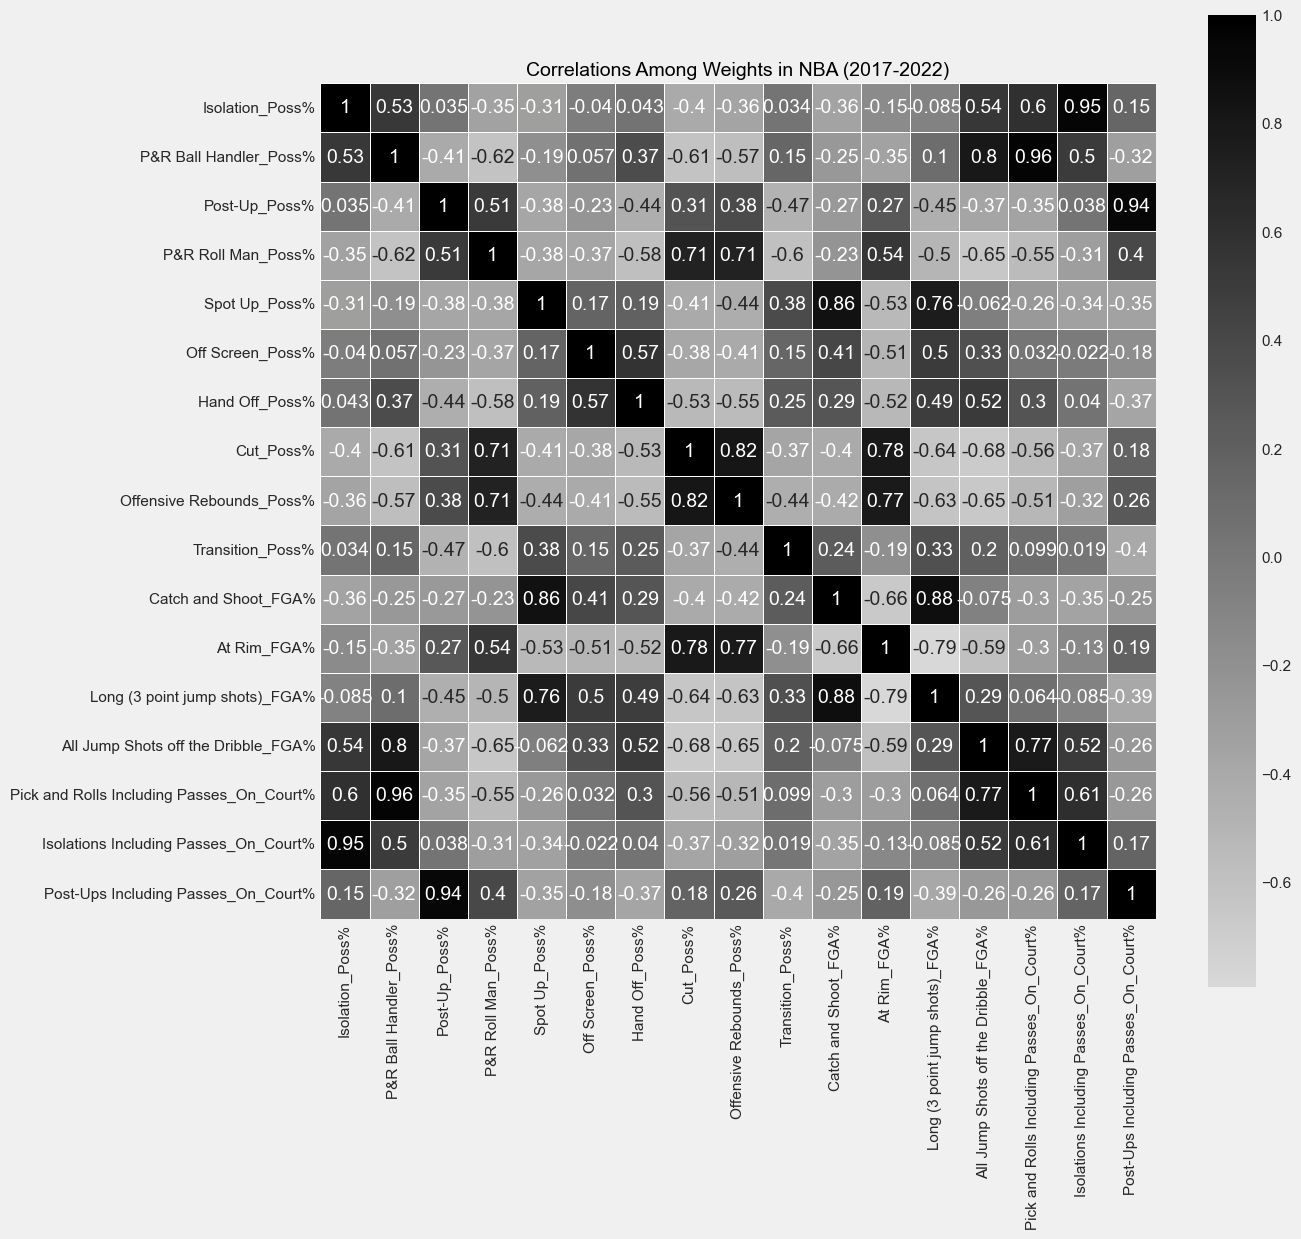

In [26]:
figsize(12, 8)
corr = df[weights].corr()
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.light_palette('black', as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap, vmax=None, center=0,
            square=True, annot=True, linewidths=.5)
plt.title('Correlations Among Weights in NBA (2017-2022)')

### Reduce Dimensions with PCA

In [27]:
X = df[weights].copy()

Determine how many components reduce down to via PCA

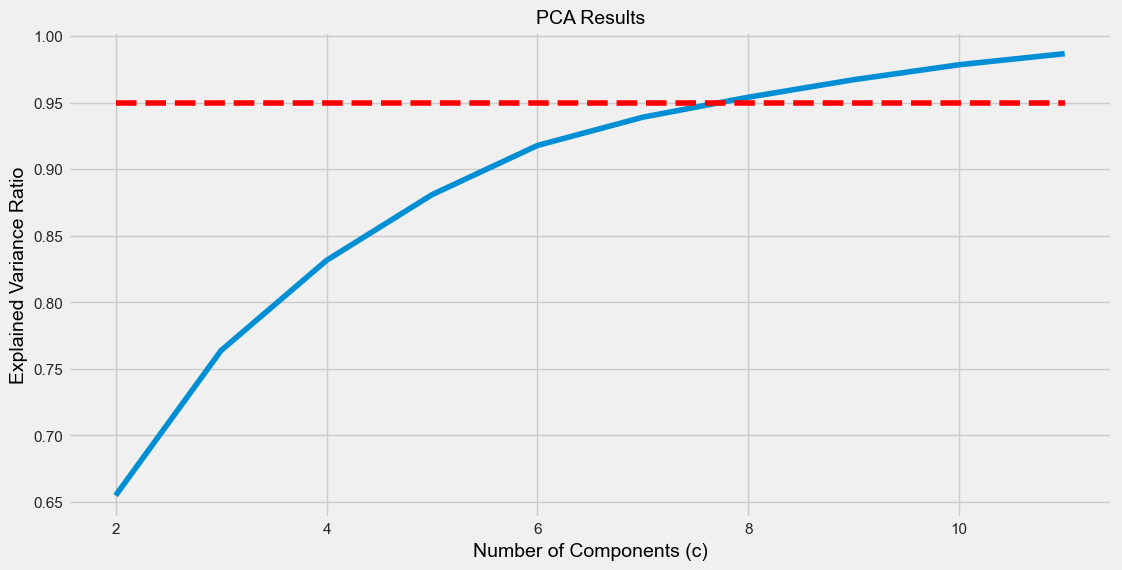

In [28]:
figsize(12, 6)
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
# pre_pca_pipe = StandardScaler()
plot_pca_explained_var(pre_pca_pipe.fit_transform(X))

Choosse 8

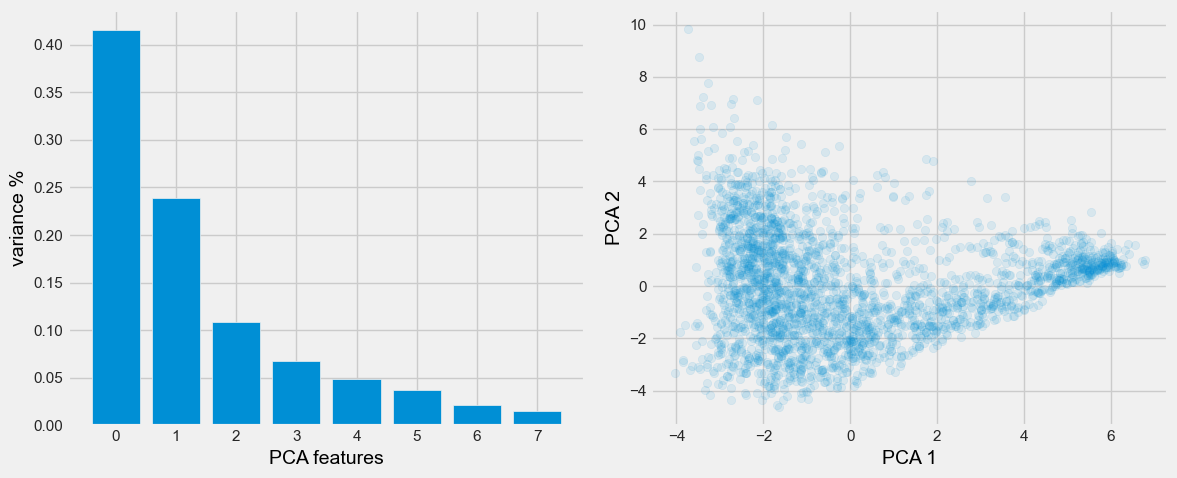

In [29]:
n_components = 8

pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
pca = PCA(n_components=n_components)
pca.fit(pre_pca_pipe.fit_transform(X))
pca_components = pca.transform(pre_pca_pipe.fit_transform(X))

figsize(12, 5)
plt.subplot(1, 2, 1)
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(range(pca.n_components_))

plt.subplot(1, 2, 2)
plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()

In [30]:
pre_cluster_scaler = StandardScaler()
X_transformed = pre_cluster_scaler.fit_transform(pca_components)

### Choose Optimal K

Determine # of clusters using silhouette score method

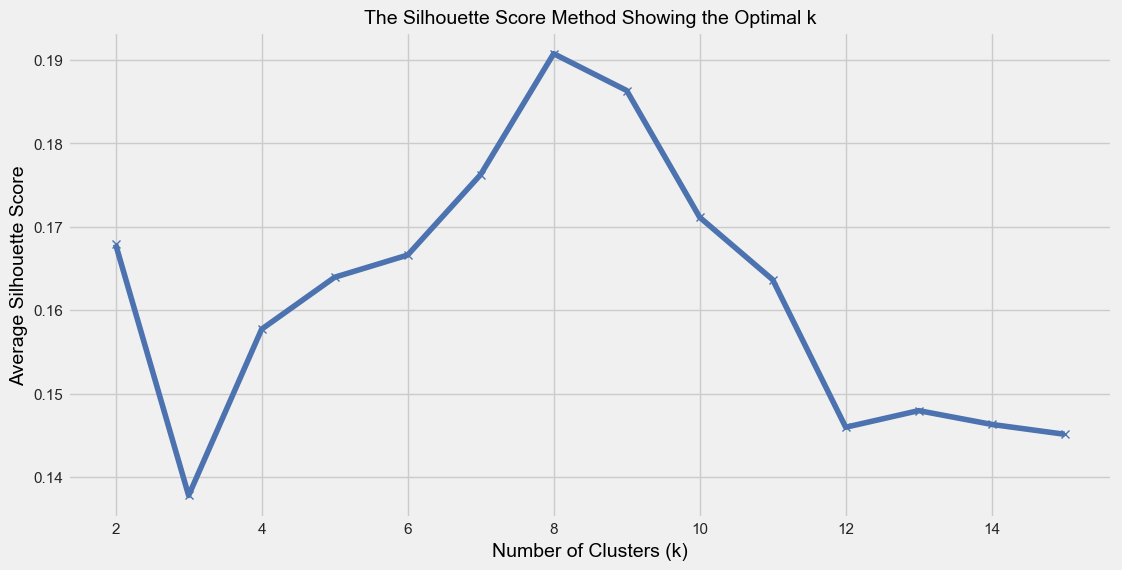

In [31]:
figsize(12, 6)
plot_silhouette_score(X_transformed)

### Clustering

In [32]:
# Choose k = 8
n_clusters = 8

sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors', 
                        random_state=42)
sc.fit(X_transformed)
df['player_cluster'] = sc.labels_
df['silhouette_coefficient'] = silhouette_samples(X_transformed, 
                                                  df['player_cluster'])
df.groupby('player_cluster').count()['Player']

player_cluster
0    951
1    166
2    289
3    213
4    700
5     45
6     96
7    116
Name: Player, dtype: int64

## Results

### Functions

In [33]:
def plot_cluster_res_2d(df, cluster_col, col1, col2, cluster_dict):
    clusters = list(set(df[cluster_col]))
    for cluster in clusters:
        cluster_cond = df[cluster_col] == cluster
        x = df[cluster_cond][col1].values * 100
        y = df[cluster_cond][col2].values * 100
        plt.scatter(x, y, 
                    label=f'Cluster {cluster}: {cluster_dict[cluster]}', 
                    alpha=0.3)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.legend()

In [34]:
def show_cluster_res(df, cluster_col, weights=weights):
    cluster_res = df.groupby(cluster_col)[['usg_pct', 'obpm', 'onpm'] + weights]\
                    .mean().sort_values('obpm', ascending=False)
    cluster_cnt = Counter(df[cluster_col])
    cluster_res['obpm'] = cluster_res['obpm'].apply(lambda x: f'{x:.2f}')
    cluster_res['onpm'] = cluster_res['onpm'].apply(lambda x: f'{x:.2f}')
    cluster_res['usg_pct'] = cluster_res['usg_pct'].apply(lambda x: f'{x:.1f}%')
    for col in cluster_res.columns:
        if '%' in col or 'Rt' in col:
            cluster_res[col] = cluster_res[col].apply(lambda x: f'{x:.1%}')
    cluster_res = cluster_res.reset_index()
    cluster_res['#'] = cluster_res[cluster_col].map(cluster_cnt)
    return cluster_res.T

### Overview

In [35]:
show_cluster_res(df, 'player_cluster')

0      1      2      3      4  \
player_cluster                                 1      3      7      6      4   
usg_pct                                    27.5%  22.8%  19.5%  14.3%  21.0%   
obpm                                        2.61   1.16   0.01  -0.44  -0.47   
onpm                                        2.97   0.62   0.96  -0.49  -0.21   
Isolation_Poss%                            18.7%   4.9%   3.2%   1.0%   7.3%   
P&R Ball Handler_Poss%                     26.5%   1.8%  12.4%   0.1%  35.5%   
Post-Up_Poss%                               6.2%  22.4%   1.3%   7.1%   0.8%   
P&R Roll Man_Poss%                          2.4%  18.3%   1.6%  20.7%   0.6%   
Spot Up_Poss%                              15.6%  15.5%  28.1%   4.7%  22.9%   
Off Screen_Poss%                            4.2%   2.0%  20.1%   0.2%   3.9%   
Hand Off_Poss%                              4.5%   1.1%   8.9%   0.1%   6.9%   
Cut_Poss%                                   3.3%  12.9%   4.4%  28.9%   2.9%   
Offensive Rebounds_Poss%                    2.6%  11.4%   2.1%  28.7%   2.0%   
Transition_Poss%                           16.1%   9.5%  17.8%   8.4%  17.2%   
Catch and Shoot_FGA%                       18.6%  22.4%  47.5%   4.0%  25.3%   
At Rim_FGA%                                32.9%  44.3%  19.0%  79.3%  28.9%   
Long (3 point jump shots)_FGA%             34.0%  20.1%  58.7%   2.4%  39.9%   
All Jump Shots off the Dribble_FGA%        32.0%   6.3%  25.0%   1.0%  32.0%   
Pick and Rolls Including Passes_On_Court%  15.1%   0.7%   4.9%   0.0%  16.1%   
Isolations Including Passes_On_Court%       7.4%   1.5%   0.9%   0.2%   2.3%   
Post-Ups Including Passes_On_Court%         2.8%   7.3%   0.4%   1.4%   0.3%   
#                                            166    213    116     96    700   

                                               5      6      7  
player_cluster                                 2      5      0  
usg_pct                                    16.8%  17.7%  16.3%  
obpm                                       -0.62  -0.77  -1.51  
onpm                                       -1.30   0.56  -1.00  
Isolation_Poss%                             1.9%   1.4%   3.4%  
P&R Ball Handler_Poss%                      0.4%  10.0%   8.2%  
Post-Up_Poss%                               6.7%   0.2%   2.6%  
P&R Roll Man_Poss%                         27.6%   1.5%   4.6%  
Spot Up_Poss%                              15.5%  28.5%  37.6%  
Off Screen_Poss%                            0.6%  13.5%   4.2%  
Hand Off_Poss%                              0.6%  22.8%   5.1%  
Cut_Poss%                                  21.6%   5.0%   8.4%  
Offensive Rebounds_Poss%                   14.5%   1.7%   5.7%  
Transition_Poss%                           10.5%  15.4%  20.2%  
Catch and Shoot_FGA%                       22.8%  51.2%  42.4%  
At Rim_FGA%                                55.2%  17.3%  34.5%  
Long (3 point jump shots)_FGA%             19.3%  63.2%  47.6%  
All Jump Shots off the Dribble_FGA%         3.1%  25.3%  13.3%  
Pick and Rolls Including Passes_On_Court%   0.1%   3.7%   2.8%  
Isolations Including Passes_On_Court%       0.4%   0.4%   0.8%  
Post-Ups Including Passes_On_Court%         1.6%   0.0%   0.7%  
#                                            289     45    951

- Ballhandler: 1 & 4
- Big: 3 & 6 & 2
- Wing: 7 & 5 & 0

In [36]:
cluster_dict = {1: 'Ballhandler', 4: 'Ballhandler',
                3: 'Big', 6: 'Big', 2: 'Big',
                7: 'Wing', 5: 'Wing', 0: 'Wing'}

In [37]:
def color_cluster(val, cluster_dict=cluster_dict):
    if cluster_dict[val] == 'Ballhandler':
        return '#AB3B3A'
    elif cluster_dict[val] == 'Wing':
        return '#2E5C6E'
    elif cluster_dict[val] == 'Big':
        return '#F7D94C'

In [38]:
def color_cluster_pandas(val, cluster_dict=cluster_dict):
    if val in cluster_dict.keys():
        color = color_cluster(val, cluster_dict=cluster_dict)
    else:
        color = 'white'
    return f'background-color: {color}' 

In [39]:
def color_pm(val):
    if float(val) >= 0:
        return 'color: red; font-weight: bold'
    else:
        return 'color: blue; font-weight: bold'

In [40]:
show_cluster_res(df, 'player_cluster')\
.style\
.applymap(color_cluster_pandas, 
          subset=pd.IndexSlice[['player_cluster'], :])\
.applymap(color_pm, 
          subset=pd.IndexSlice[['obpm', 'onpm'],:])\
.applymap(lambda x: 'background-color: #AB3B3A', 
          subset=pd.IndexSlice[['P&R Ball Handler_Poss%',
                                'All Jump Shots off the Dribble_FGA%',
                                'Pick and Rolls Including Passes_On_Court%'], 
                               [0, 4]])\
.applymap(lambda x: 'background-color: #F7D94C', 
          subset=pd.IndexSlice[['P&R Roll Man_Poss%',
                                'Post-Up_Poss%',
                                'Cut_Poss%',
                                'Offensive Rebounds_Poss%',
                                'At Rim_FGA%'], 
                               [1, 3, 5]])\
.applymap(lambda x: 'background-color: #2E5C6E', 
          subset=pd.IndexSlice[['Spot Up_Poss%',
                                'Catch and Shoot_FGA%',
                                'Long (3 point jump shots)_FGA%'], 
                               [2, 6, 7]])\
.applymap(lambda x: 'color: red; font-weight: bold',
          subset=pd.IndexSlice[['Post-Ups Including Passes_On_Court%'],
                               [0, 1]])\
.applymap(lambda x: 'background-color: #69B0AC',
          subset=pd.IndexSlice[['#'], [4, 5, 7]])

In [41]:
cluster_dict_detail = {
    1: '(Iso+PnR)', 
    4: '(PnR)',                    
    3: '(Post Up+Roll)', 
    6: '(Roll+Cut)',
    2: '(Roll+Spot Up)',
    7: '(Off Screen)', 
    5: '(Hand Off)', 
    0: '(Spot Up+Transition)'
}

Text(0.5, 1.0, 'Single-Season OBPM by Cluster [NBA]\n(2017-2022)\nMinimum Minutes Played: 1000')

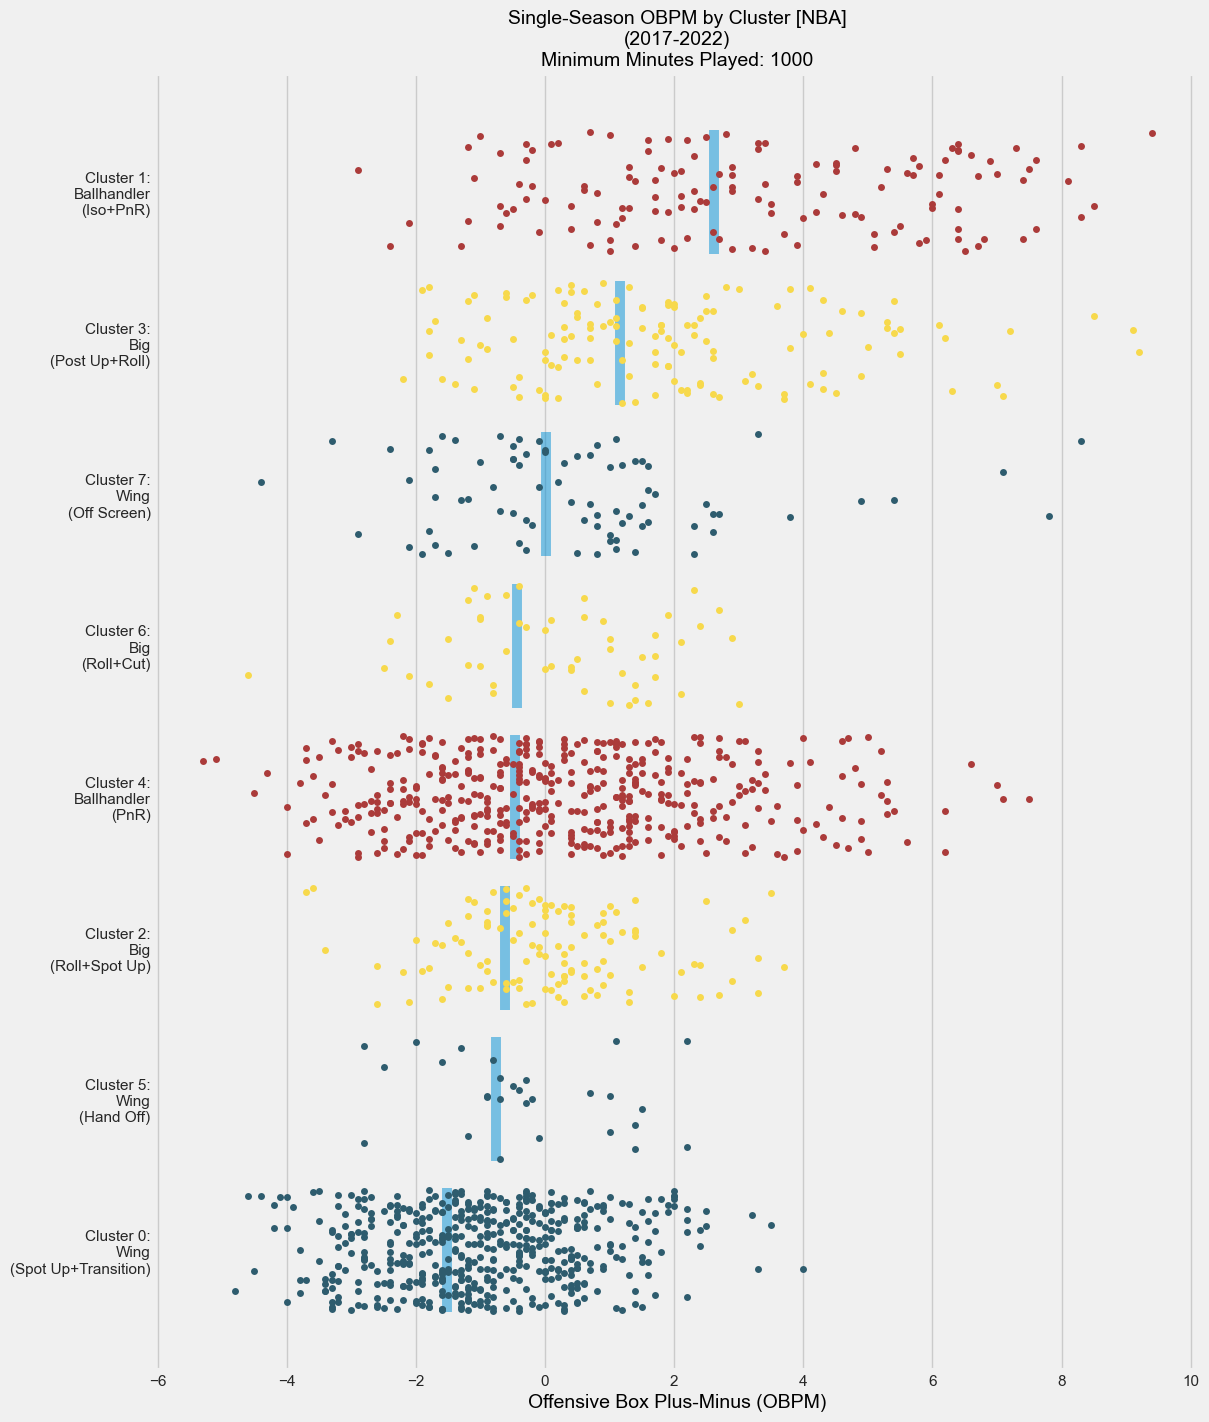

In [43]:
figsize(12, 16)

cluster_obpm_order = [1, 3, 7, 6, 4, 2, 5, 0]
df['player_cluster_alt'] = df['player_cluster']\
.apply(lambda x: f'Cluster {x}:\n{cluster_dict[x]}\n{cluster_dict_detail[x]}')
avg_obpm_df = df.groupby('player_cluster_alt')[['obpm']].mean().reset_index()

for c in cluster_obpm_order:
    sns.stripplot(data=df[(df['player_cluster'] == c) &
                          (df['mp'] >= 1000)],
                  x='obpm', 
                  y='player_cluster_alt',
                  jitter=0.4,
                  color=color_cluster(c))
    plt.ylabel('')
    
sns.scatterplot(data=avg_obpm_df,
                    x='obpm', 
                    y='player_cluster_alt',
                    marker='|', 
                    s=8000, 
#                     color='blue',
                    alpha=0.5)
plt.ylabel('')
plt.xlabel('Offensive Box Plus-Minus (OBPM)')
plt.title('Single-Season OBPM by Cluster [NBA]\n(2017-2022)\nMinimum Minutes Played: 1000')

### Observations

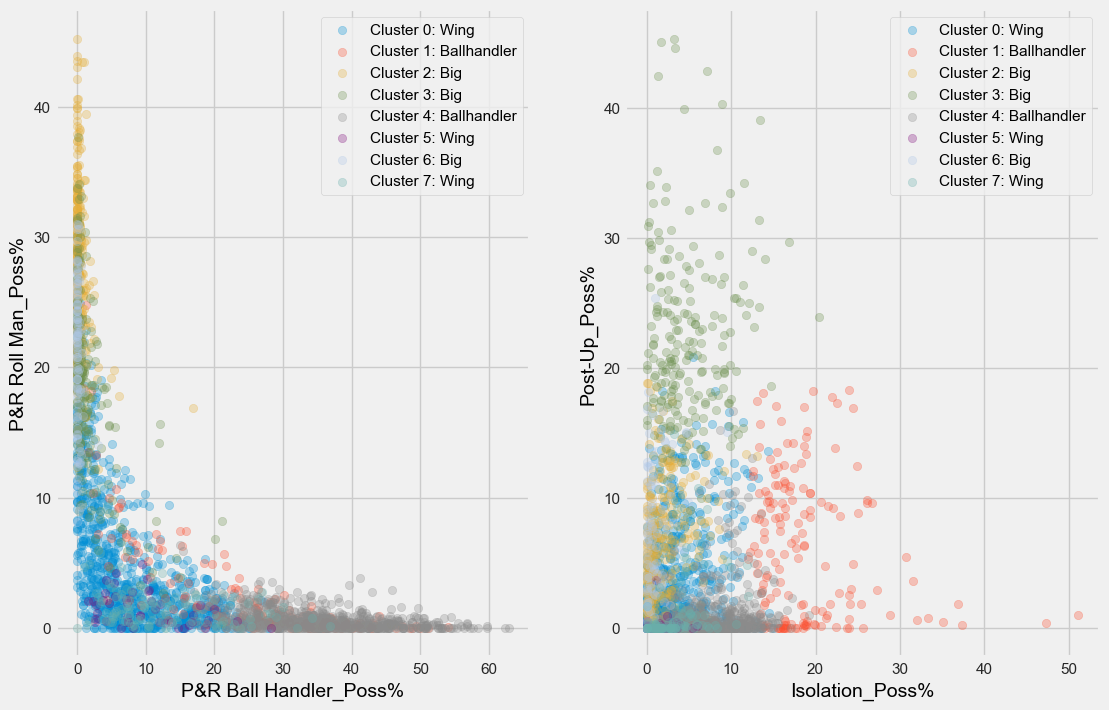

In [44]:
figsize(12, 8)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='P&R Roll Man_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='Isolation_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)

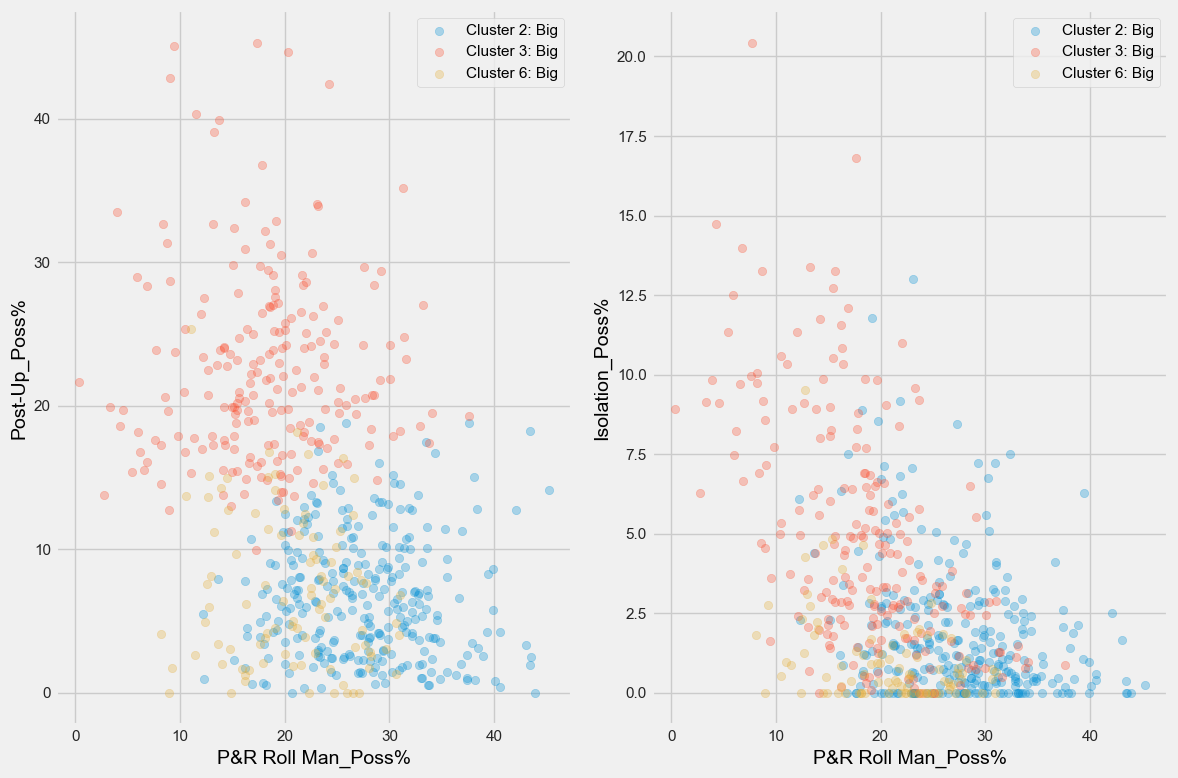

In [45]:
figsize(12, 8)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

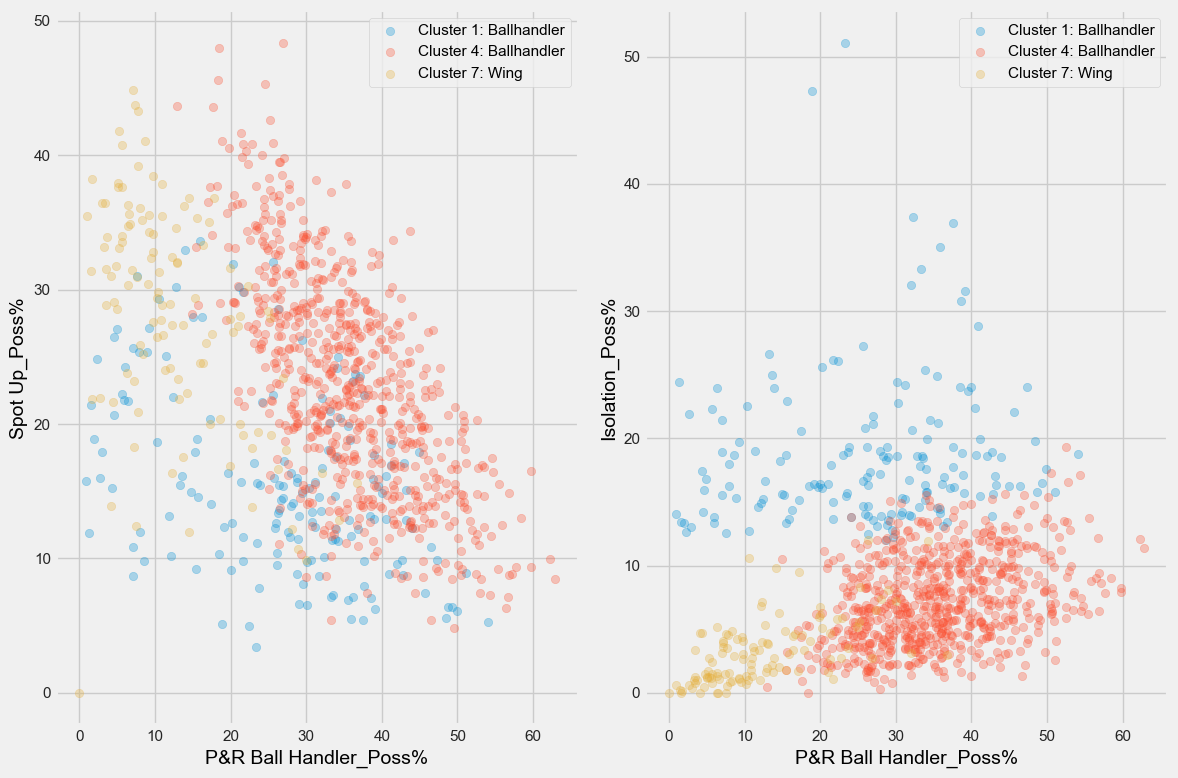

In [46]:
figsize(12, 8)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster in [1, 7, 4]])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Spot Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster in [1, 7, 4]])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

### Distributions

In [48]:
cluster_dict_detail

{1: '(Iso+PnR)',
 4: '(PnR)',
 3: '(Post Up+Roll)',
 6: '(Roll+Cut)',
 2: '(Roll+Spot Up)',
 7: '(Off Screen)',
 5: '(Hand Off)',
 0: '(Spot Up+Transition)'}

In [49]:
cluster_order = [1, 4, 7, 5, 0, 2, 3, 6]

Height & Weight

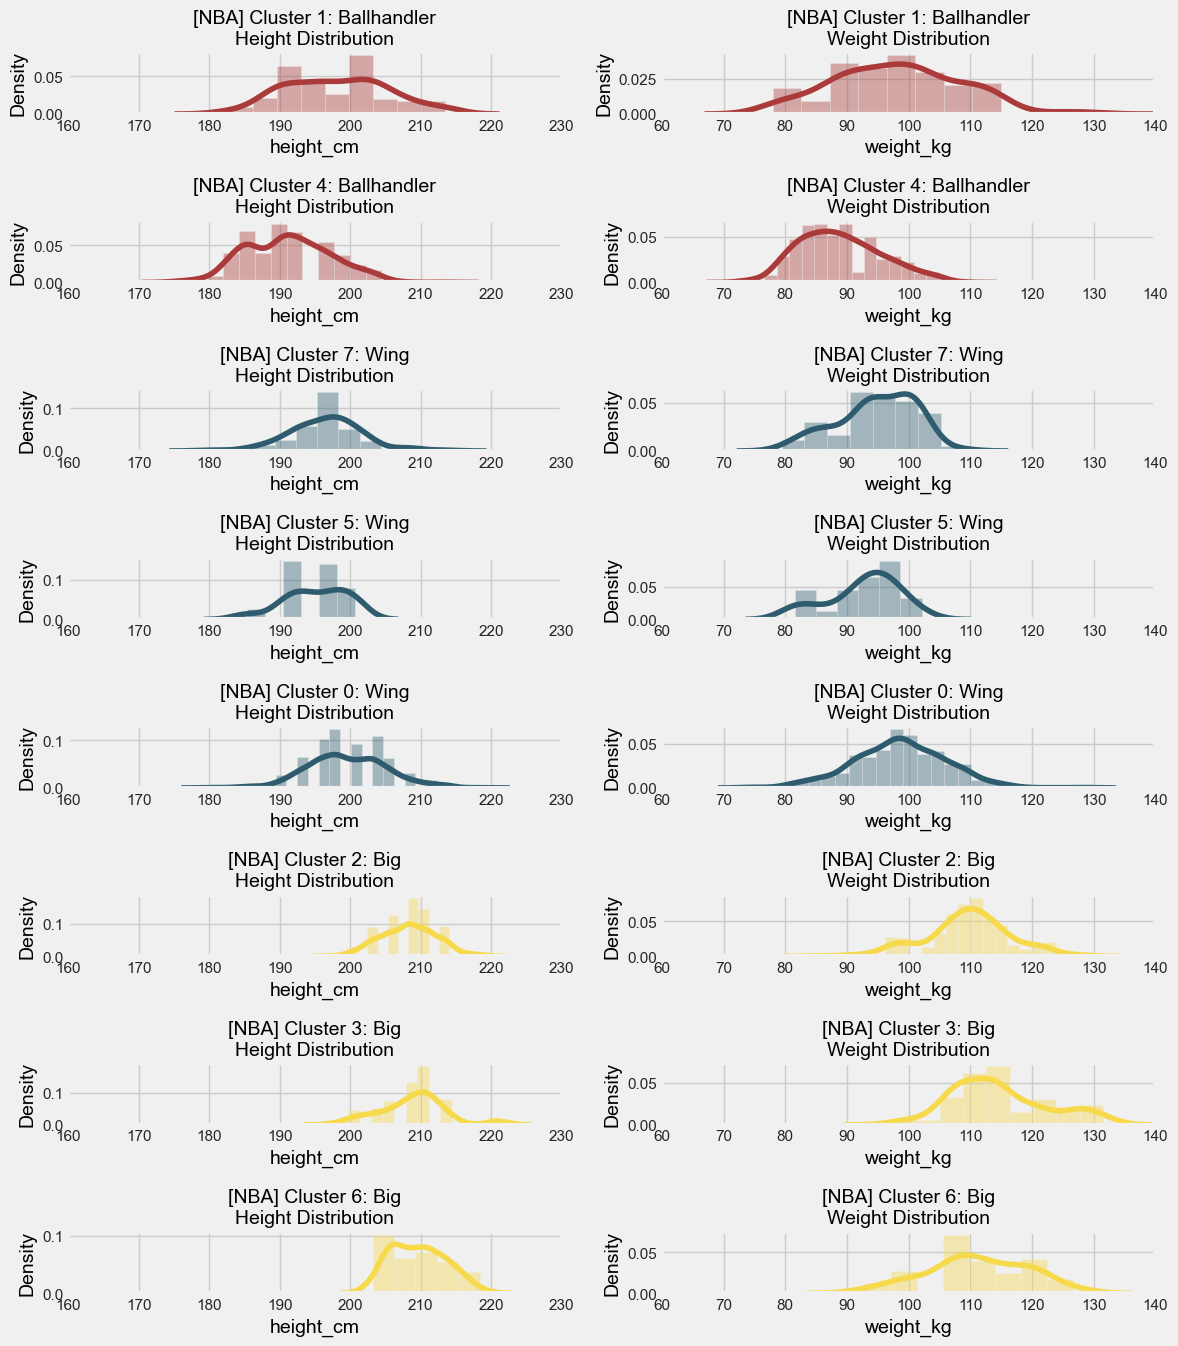

In [50]:
figsize(12, 20)
for idx, cluster in enumerate(cluster_order, 0):
    color = color_cluster(cluster)
    plt.subplot(12, 2, idx*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['height_cm'],
                 color=color)
    plt.title(f'[NBA] Cluster {cluster}: {cluster_dict[cluster]}\nHeight Distribution')
    plt.xlim(160, 230)
    plt.subplot(12, 2, idx*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['weight_kg'],
                 color=color)
    plt.title(f'[NBA] Cluster {cluster}: {cluster_dict[cluster]}\nWeight Distribution')
    plt.xlim(60, 140)
plt.tight_layout()

Usage & True Shooting

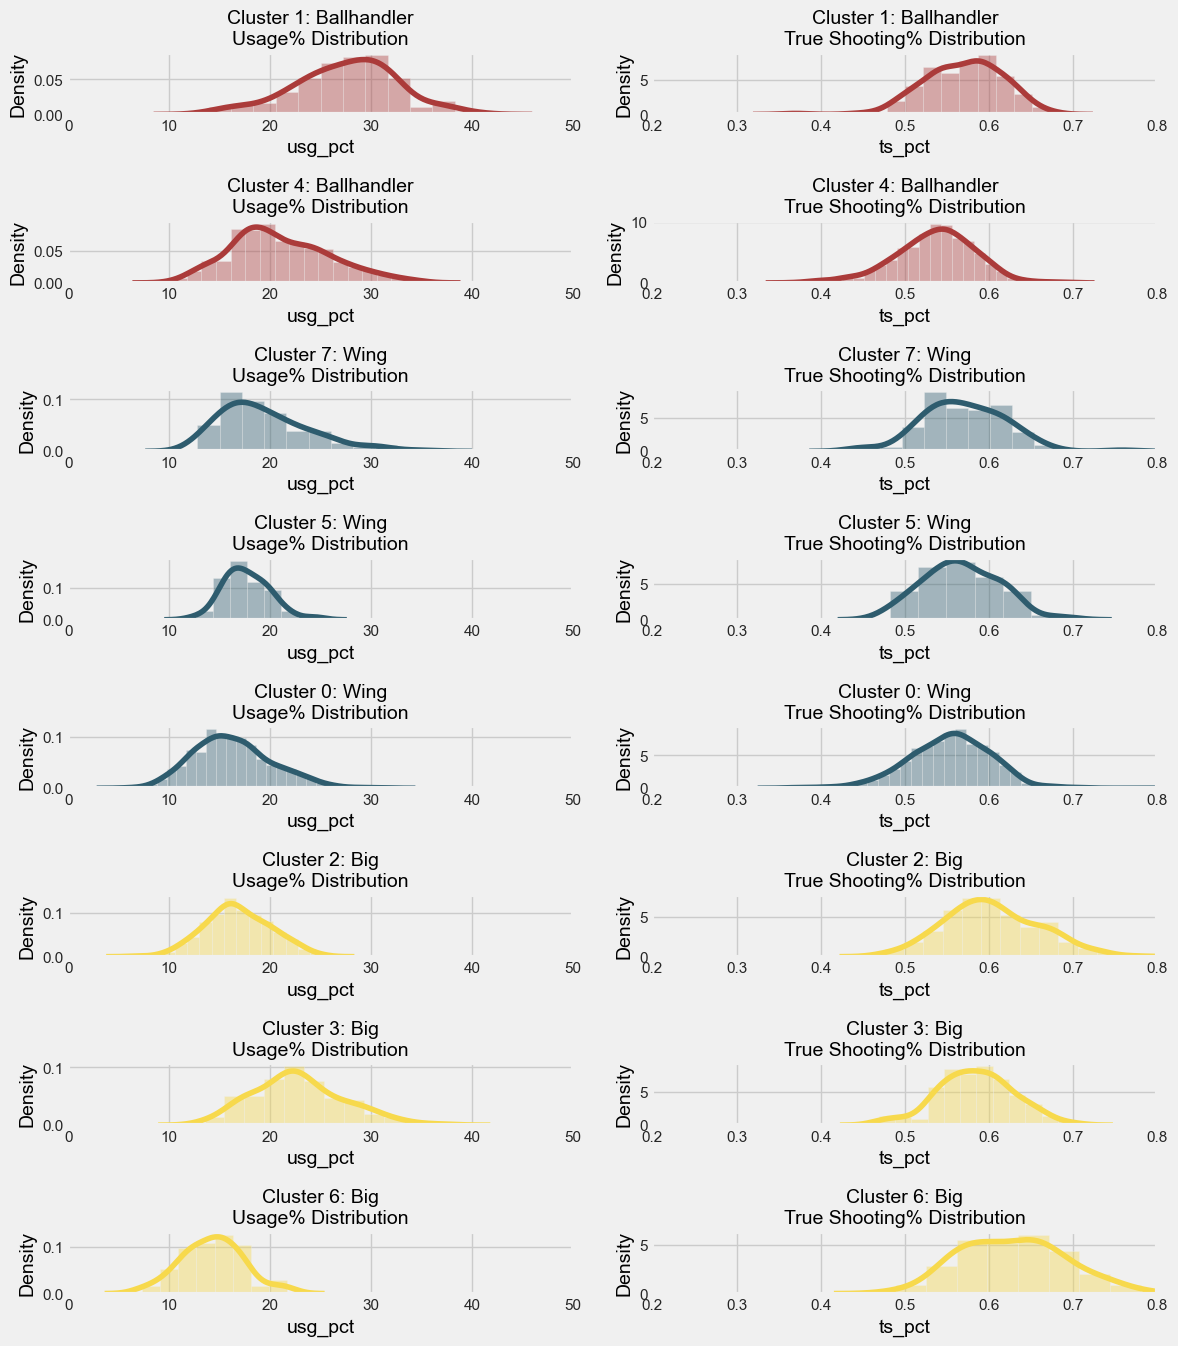

In [51]:
figsize(12, 20)
for i, cluster in enumerate(cluster_order, 0):
    color = color_cluster(cluster)
    plt.subplot(12, 2, i*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['usg_pct'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nUsage% Distribution')
    plt.xlim(0, 50)
    plt.subplot(12, 2, i*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['ts_pct'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nTrue Shooting% Distribution')
    plt.xlim(0.2, 0.8)
plt.tight_layout()

OBPM & ONPM

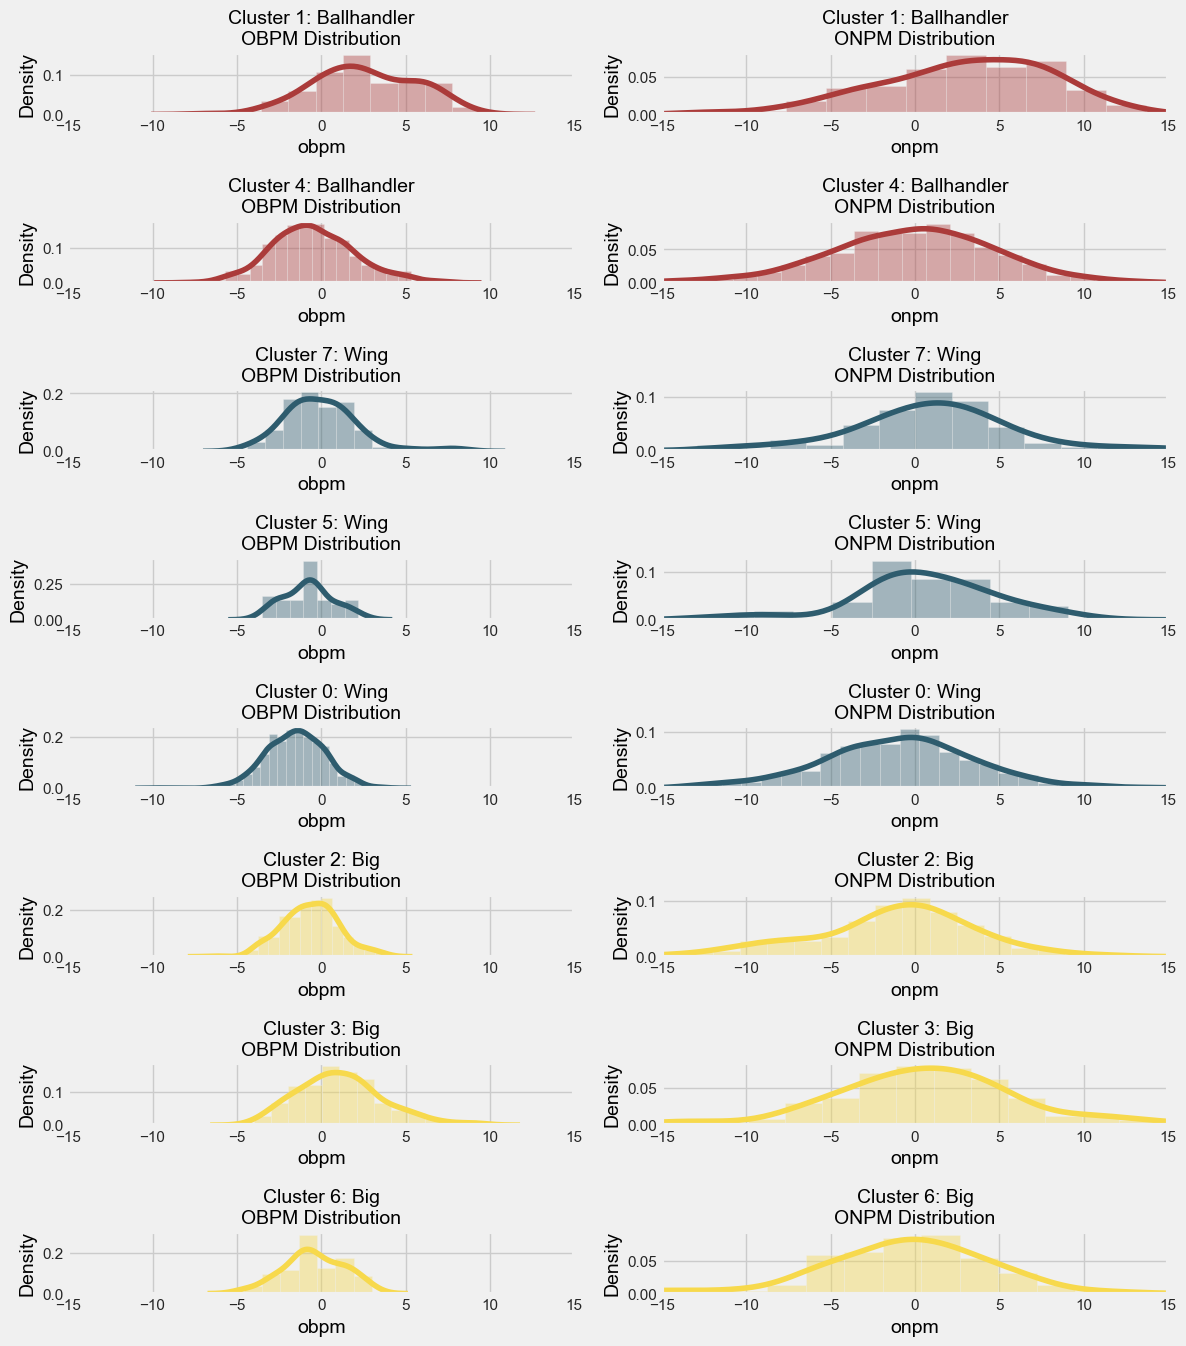

In [52]:
figsize(12, 20)
for i, cluster in enumerate(cluster_order, 0):
    color = color_cluster(cluster)
    plt.subplot(12, 2, i*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['obpm'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nOBPM Distribution')
    plt.xlim(-15, 15)
    plt.subplot(12, 2, i*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['onpm'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nONPM Distribution')
    plt.xlim(-15, 15)
plt.tight_layout()

OBPM & DBPM

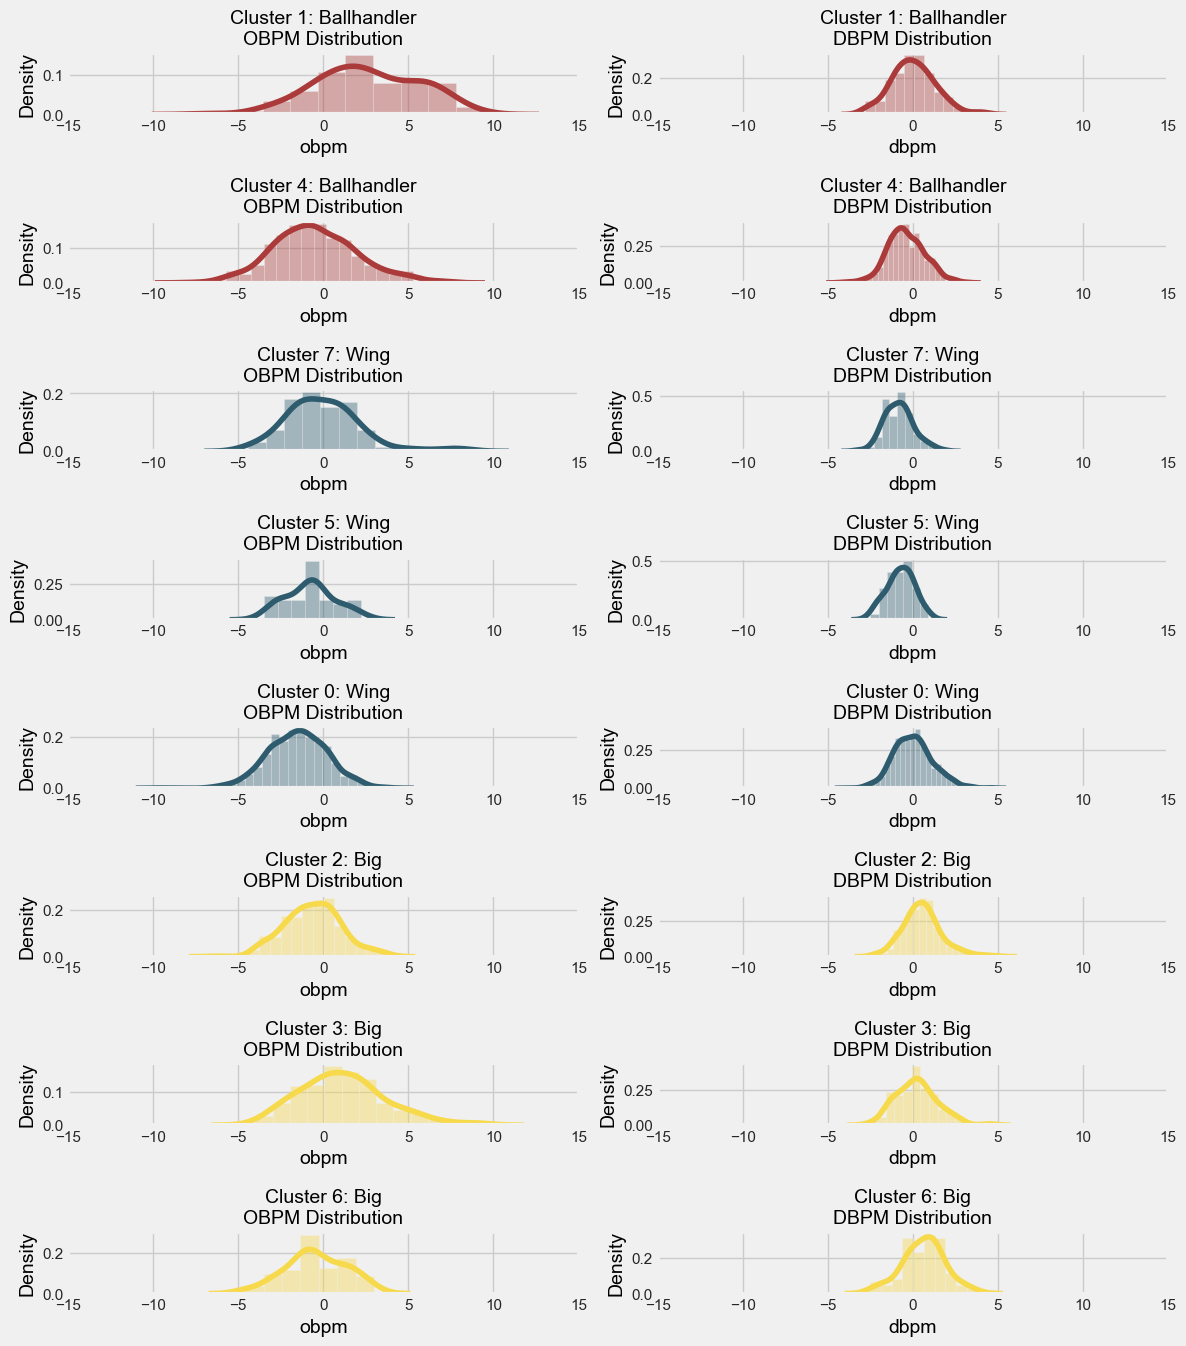

In [53]:
figsize(12, 20)
for i, cluster in enumerate(cluster_order, 0):
    color = color_cluster(cluster)
    plt.subplot(12, 2, i*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['obpm'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nOBPM Distribution')
    plt.xlim(-15, 15)
    plt.subplot(12, 2, i*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['dbpm'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nDBPM Distribution')
    plt.xlim(-15, 15)
plt.tight_layout()

### Top & Bottom Players by Cluster

In [54]:
def display_cluster_players(df, cluster_col, cluster_label, 
                            n=5, mp_min=300):
    cols = ['Player', 'Season', 'Team', 'obpm']
    temp = df[df['mp'] >= mp_min]
    best_10 = temp[temp[cluster_col] == cluster_label].sort_values('obpm', ascending=False)\
                                                      .head(n)[cols]\
                                                      .rename(columns={'Player': f'Best {n} Players'})\
                                                      .reset_index().drop('index', axis=1)
    worst_10 = temp[temp[cluster_col] == cluster_label].sort_values('obpm')\
                                                       .head(n)[cols]\
                                                       .rename(columns={'Player': f'Worst {n} Players'})\
                                                       .reset_index().drop('index', axis=1)
    return pd.concat([best_10, worst_10], axis=1)

Ballhandlers

In [56]:
c = 1
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 166


Best 5 Players     Season                    Team  obpm   Worst 5 Players  \
0    James Harden  2018-2019         Houston Rockets   9.4       Theo Pinson   
1    James Harden  2017-2018         Houston Rockets   8.5     Austin Rivers   
2  Damian Lillard  2022-2023  Portland Trail Blazers   8.3      Keon Johnson   
3  Damian Lillard  2019-2020  Portland Trail Blazers   8.3       Harry Giles   
4    James Harden  2019-2020         Houston Rockets   8.1  Shabazz Muhammad   

      Season                    Team  obpm  
0  2019-2020           Brooklyn Nets  -6.8  
1  2018-2019      Washington Wizards  -4.1  
2  2022-2023  Portland Trail Blazers  -3.8  
3  2020-2021  Portland Trail Blazers  -3.2  
4  2017-2018  Minnesota Timberwolves  -3.1

In [57]:
c = 4
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 700


Best 5 Players     Season                    Team  obpm  \
0      Stephen Curry  2022-2023   Golden State Warriors   7.5   
1         Trae Young  2021-2022           Atlanta Hawks   7.1   
2  Tyrese Haliburton  2022-2023          Indiana Pacers   7.0   
3       Kyrie Irving  2019-2020           Brooklyn Nets   6.7   
4     Damian Lillard  2018-2019  Portland Trail Blazers   6.6   

   Worst 5 Players     Season                Team  obpm  
0     Blake Wesley  2022-2023   San Antonio Spurs  -7.9  
1  Jerome Robinson  2020-2021  Washington Wizards  -6.9  
2    Killian Hayes  2020-2021     Detroit Pistons  -6.3  
3    Avery Bradley  2020-2021     Houston Rockets  -6.2  
4  Justise Winslow  2020-2021   Memphis Grizzlies  -6.2

In [58]:
list(df[df['player_cluster'] == 1].sort_values('height_cm')['Player'].tail(50))

['Jayson Tatum',
 'Brandon Ingram',
 'Marcus Morris',
 'Julius Randle',
 'Jayson Tatum',
 'Marcus Morris',
 'Brandon Ingram',
 'Jabari Parker',
 'Tobias Harris',
 'Brandon Ingram',
 'Julius Randle',
 'Jerami Grant',
 'Julius Randle',
 'Julius Randle',
 'Brandon Ingram',
 'Harrison Barnes',
 'Rudy Gay',
 'Rudy Gay',
 'Julius Randle',
 'Michael Beasley',
 'LeBron James',
 'LeBron James',
 'LeBron James',
 'LeBron James',
 'LeBron James',
 'Pascal Siakam',
 'Pascal Siakam',
 'LeBron James',
 'Pascal Siakam',
 'Pascal Siakam',
 'Christian Wood',
 'Paolo Banchero',
 'Kevin Durant',
 'Danilo Gallinari',
 'Kevin Durant',
 'Kevin Durant',
 'Kevin Durant',
 'Danilo Gallinari',
 'DeMarcus Cousins',
 'Kevin Durant',
 'Karl-Anthony Towns',
 'Harry Giles',
 'Karl-Anthony Towns',
 'Giannis Antetokounmpo',
 'Giannis Antetokounmpo',
 'Giannis Antetokounmpo',
 'Giannis Antetokounmpo',
 'Giannis Antetokounmpo',
 'Joel Embiid',
 'Giannis Antetokounmpo']

In [59]:
list(df[df['player_cluster'] == 4].sort_values('height_cm')['Player'].tail(50))

['Andrew Wiggins',
 'Gordon Hayward',
 'Khris Middleton',
 'Tomas Satoransky',
 'Dillon Brooks',
 'LaMelo Ball',
 'LaMelo Ball',
 'Jimmy Butler',
 'Amir Coffey',
 'Tomas Satoransky',
 'Tomas Satoransky',
 'Evan Fournier',
 'Gordon Hayward',
 'Dillon Brooks',
 'Dillon Brooks',
 'Andrew Wiggins',
 'Luka Doncic',
 'Jerami Grant',
 'Otto Porter Jr.',
 'Paul George',
 'Nicolas Batum',
 'Marcus Morris',
 'Otto Porter Jr.',
 'Rodney Hood',
 'Josh Jackson',
 'DeAndre Hunter',
 'Brandon Ingram',
 'Rodney Hood',
 'Tobias Harris',
 'Joe Ingles',
 'Joe Ingles',
 'Joe Ingles',
 'Brandon Ingram',
 'Tobias Harris',
 'Jordan Nwora',
 'Josh Giddey',
 'Rodney Hood',
 'Joe Ingles',
 'Mario Hezonja',
 'Josh Giddey',
 'Rodney Hood',
 'Joe Ingles',
 'Cameron Reddish',
 'Otto Porter Jr.',
 'Chandler Parsons',
 'Jeremy Sochan',
 'Franz Wagner',
 'Chandler Parsons',
 'Ben Simmons',
 'Aleksej Pokusevski']

Bigs

In [61]:
c = 3
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 213


Best 5 Players     Season                  Team  obpm Worst 5 Players  \
0   Nikola Jokic  2021-2022        Denver Nuggets   9.2   James Wiseman   
1   Nikola Jokic  2020-2021        Denver Nuggets   9.1     Greg Monroe   
2   Nikola Jokic  2022-2023        Denver Nuggets   8.5     Harry Giles   
3    Joel Embiid  2021-2022    Philadelphia 76ers   7.2  Timofey Mozgov   
4  Anthony Davis  2018-2019  New Orleans Pelicans   7.1     Joe Johnson   

      Season                   Team  obpm  
0  2020-2021  Golden State Warriors  -4.0  
1  2018-2019        Toronto Raptors  -3.5  
2  2018-2019       Sacramento Kings  -3.4  
3  2017-2018          Brooklyn Nets  -3.3  
4  2017-2018        Houston Rockets  -3.3

In [62]:
c = 6
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 96


Best 5 Players     Season            Team  obpm   Worst 5 Players  \
0          Rudy Gobert  2018-2019       Utah Jazz   3.0       Ian Mahinmi   
1          Rudy Gobert  2021-2022       Utah Jazz   2.9          Ed Davis   
2  Robert Williams III  2020-2021  Boston Celtics   2.9  Christian Koloko   
3         Clint Capela  2020-2021   Atlanta Hawks   2.7   Dominick Barlow   
4  Robert Williams III  2021-2022  Boston Celtics   2.4    Wenyen Gabriel   

      Season                Team  obpm  
0  2017-2018  Washington Wizards  -4.6  
1  2019-2020           Utah Jazz  -4.6  
2  2022-2023     Toronto Raptors  -4.3  
3  2022-2023   San Antonio Spurs  -3.7  
4  2021-2022  Los Angeles Lakers  -3.3

In [63]:
c = 2
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 289


Best 5 Players     Season                   Team  obpm   Worst 5 Players  \
0    Mike Muscala  2021-2022  Oklahoma City Thunder   3.8    Dewayne Dedmon   
1    John Collins  2019-2020          Atlanta Hawks   3.7      Goga Bitadze   
2  Christian Wood  2019-2020        Detroit Pistons   3.5  Anzejs Pasecniks   
3    Clint Capela  2018-2019        Houston Rockets   3.3      Gorgui Dieng   
4      Al Horford  2018-2019         Boston Celtics   3.3     Moritz Wagner   

      Season                Team  obpm  
0  2019-2020    Sacramento Kings  -6.3  
1  2019-2020      Indiana Pacers  -4.1  
2  2019-2020  Washington Wizards  -4.1  
3  2022-2023   San Antonio Spurs  -4.0  
4  2018-2019  Los Angeles Lakers  -3.9

Wings

In [65]:
c = 7
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 116


Best 5 Players     Season                   Team  obpm Worst 5 Players  \
0    Stephen Curry  2020-2021  Golden State Warriors   8.3    Jordan Poole   
1    Stephen Curry  2017-2018  Golden State Warriors   7.8  Carsen Edwards   
2    Stephen Curry  2018-2019  Golden State Warriors   7.1  Svi Mykhailiuk   
3    Stephen Curry  2021-2022  Golden State Warriors   5.4    Ben McLemore   
4  Lauri Markkanen  2022-2023              Utah Jazz   4.9       Ian Clark   

      Season                   Team  obpm  
0  2019-2020  Golden State Warriors  -4.4  
1  2019-2020         Boston Celtics  -4.4  
2  2018-2019     Los Angeles Lakers  -4.1  
3  2020-2021        Houston Rockets  -3.4  
4  2018-2019   New Orleans Pelicans  -3.3

In [66]:
c = 5
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 45


Best 5 Players     Season                Team  obpm  Worst 5 Players  \
0        JJ Redick  2017-2018  Philadelphia 76ers   2.2  Duncan Robinson   
1        JJ Redick  2018-2019  Philadelphia 76ers   2.2     Allen Crabbe   
2  Duncan Robinson  2019-2020          Miami Heat   1.5      Gary Harris   
3   Doug McDermott  2020-2021      Indiana Pacers   1.4    Avery Bradley   
4    Kevin Huerter  2022-2023    Sacramento Kings   1.4    Terrence Ross   

      Season             Team  obpm  
0  2022-2023       Miami Heat  -3.5  
1  2019-2020    Atlanta Hawks  -3.1  
2  2019-2020   Denver Nuggets  -2.8  
3  2017-2018  Detroit Pistons  -2.8  
4  2022-2023    Orlando Magic  -2.7

In [67]:
c = 0
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 951


Best 5 Players     Season               Team  obpm  Worst 5 Players  \
0  Michael Porter Jr.  2020-2021     Denver Nuggets   4.0        Josh Hall   
1         Buddy Hield  2018-2019   Sacramento Kings   3.5    Elijah Hughes   
2        Desmond Bane  2022-2023  Memphis Grizzlies   3.3        KZ Okpala   
3        Jaylen Brown  2020-2021     Boston Celtics   3.2    Deonte Burton   
4     Cameron Johnson  2022-2023       Phoenix Suns   3.2  Frank Ntilikina   

      Season                    Team  obpm  
0  2020-2021   Oklahoma City Thunder  -9.7  
1  2021-2022  Portland Trail Blazers  -6.6  
2  2020-2021              Miami Heat  -6.5  
3  2019-2020   Oklahoma City Thunder  -6.3  
4  2022-2023        Dallas Mavericks  -6.1

### Edge Cases

In [68]:
temp = df.groupby('Player')['player_cluster'].apply(list).reset_index()
temp['player_cluster_adj'] = temp['player_cluster'].apply(lambda x: [cluster_dict[s] 
                                                                     for s in x])\
                                                   .apply(set)
temp['player_cluster'] = temp['player_cluster'].apply(set)
temp['n_cluster'] = temp['player_cluster_adj'].apply(len)
temp[temp['n_cluster'] == 3]

Player player_cluster        player_cluster_adj  n_cluster
12   Aleksej Pokusevski      {0, 2, 4}  {Ballhandler, Wing, Big}          3
104      Christian Wood      {0, 1, 2}  {Ballhandler, Wing, Big}          3
153    DeMarcus Cousins      {0, 1, 3}  {Ballhandler, Wing, Big}          3
246     Harrison Barnes      {0, 1, 3}  {Ballhandler, Wing, Big}          3
308       James Johnson      {0, 1, 2}  {Ballhandler, Wing, Big}          3
331        Jerami Grant   {0, 1, 2, 4}  {Ballhandler, Wing, Big}          3
480       Marcus Morris   {0, 1, 3, 4}  {Ballhandler, Wing, Big}          3

In [69]:
temp[(temp['n_cluster'] == 2) & 
     (temp['player_cluster_adj'] == set(['Ballhandler', 'Big']))]

Player player_cluster  player_cluster_adj  n_cluster
87      Carmelo Anthony         {1, 3}  {Ballhandler, Big}          2
128    Danilo Gallinari         {1, 3}  {Ballhandler, Big}          2
215         Evan Turner         {3, 4}  {Ballhandler, Big}          2
247         Harry Giles      {1, 2, 3}  {Ballhandler, Big}          2
349         Joel Embiid         {1, 3}  {Ballhandler, Big}          2
389       Julius Randle         {1, 3}  {Ballhandler, Big}          2
399  Karl-Anthony Towns         {1, 3}  {Ballhandler, Big}          2
727     Zion Williamson         {1, 3}  {Ballhandler, Big}          2

## Visualization via TSNE

In [71]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.2.1.


Changed in version 1.2: The default value changed to "pca".  
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE

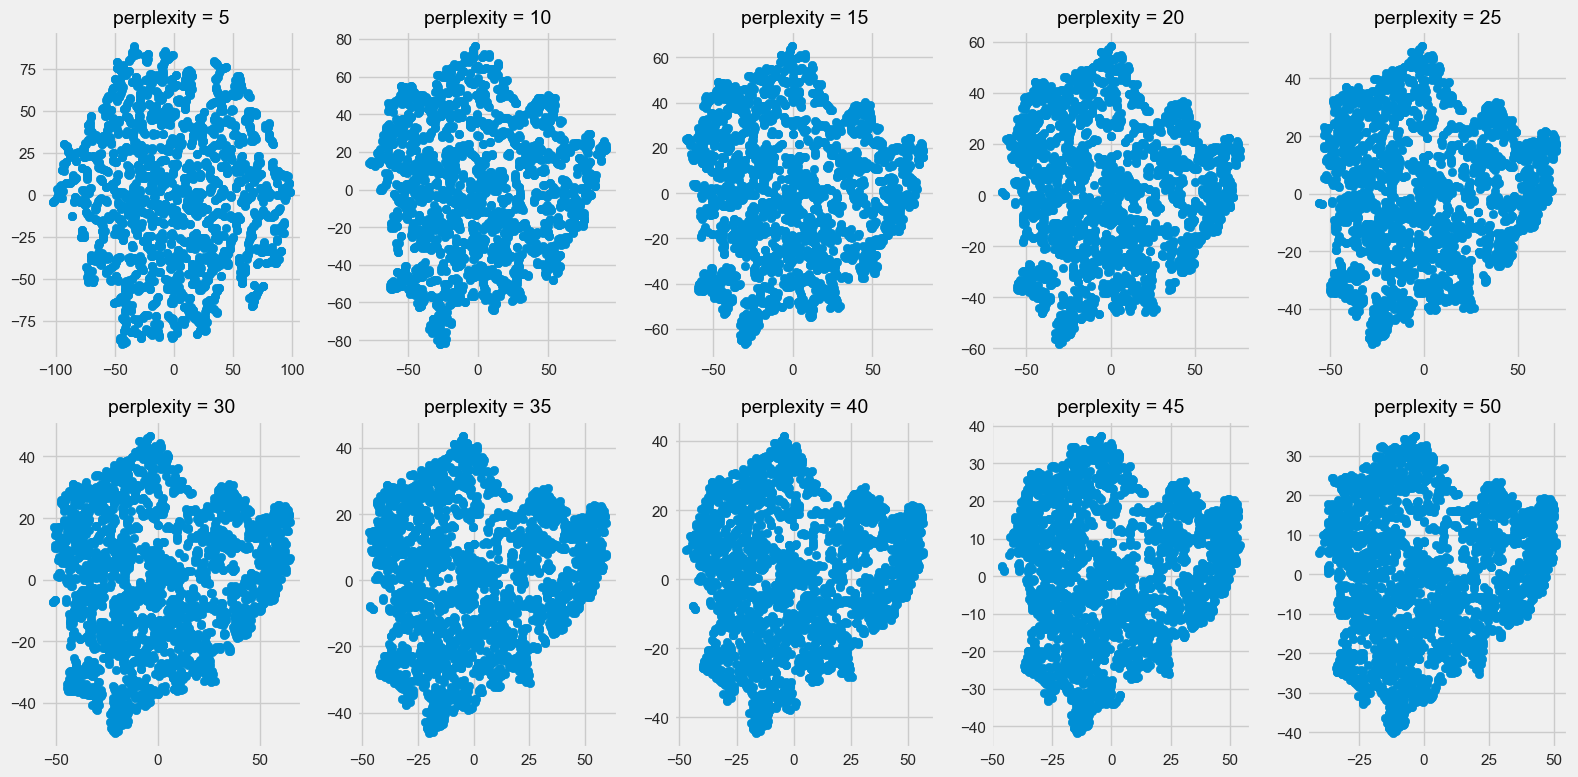

In [72]:
figsize(16, 8)
for i in list(range(1, 11)):
    plt.subplot(2, 5, i)
    perplexity = 5 * i
    tsne = TSNE(perplexity=perplexity, 
#                 early_exaggeration=4,
                init='random',
                random_state=42)
    X_tsne = tsne.fit_transform(X_transformed)
    plt.scatter(X_tsne[:,0], X_tsne[:, 1])
    plt.title(f'perplexity = {perplexity}')
plt.tight_layout()

In [75]:
perplexity = 25
tsne = TSNE(perplexity=perplexity, 
#             early_exaggeration=4,
            init='random',
            random_state=42)
X_tsne = tsne.fit_transform(X_transformed)

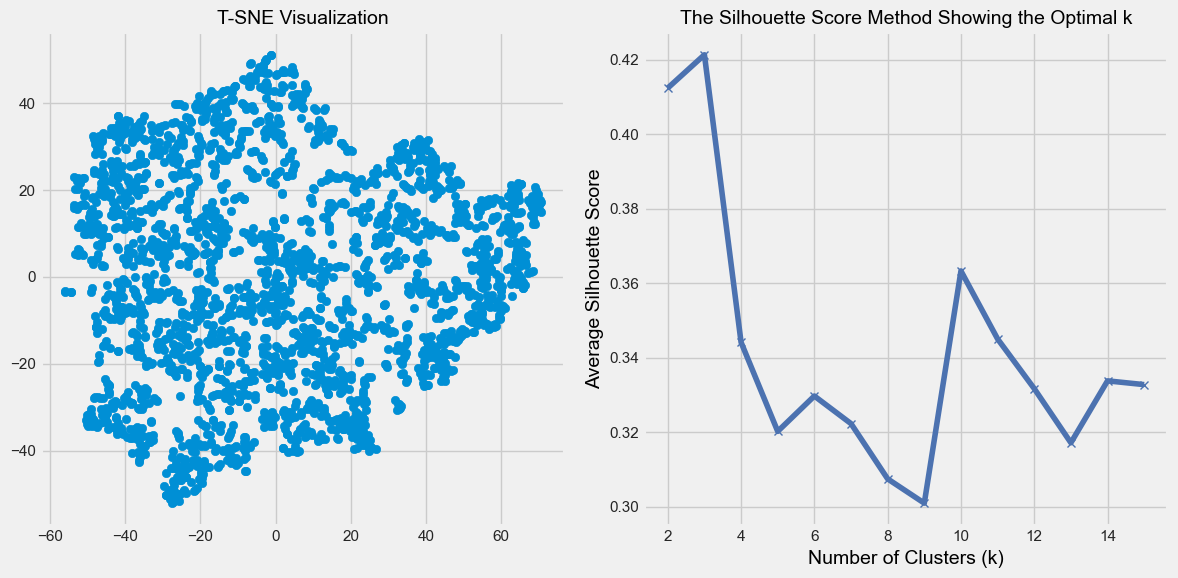

In [76]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1])
plt.title('T-SNE Visualization')
plt.subplot(1, 2, 2)
plot_silhouette_score(X_tsne)
plt.tight_layout()

In [77]:
df_tsne = df.copy()
n_clusters_tsne = 3

sc_tsne = SpectralClustering(n_clusters=n_clusters_tsne, 
                             affinity='nearest_neighbors', 
                             random_state=42)
sc_tsne.fit(X_tsne)
df_tsne['cluster_label_tsne'] = sc_tsne.labels_

In [78]:
upper_limit = 60
lower_limit = -120
loc = 'lower right'

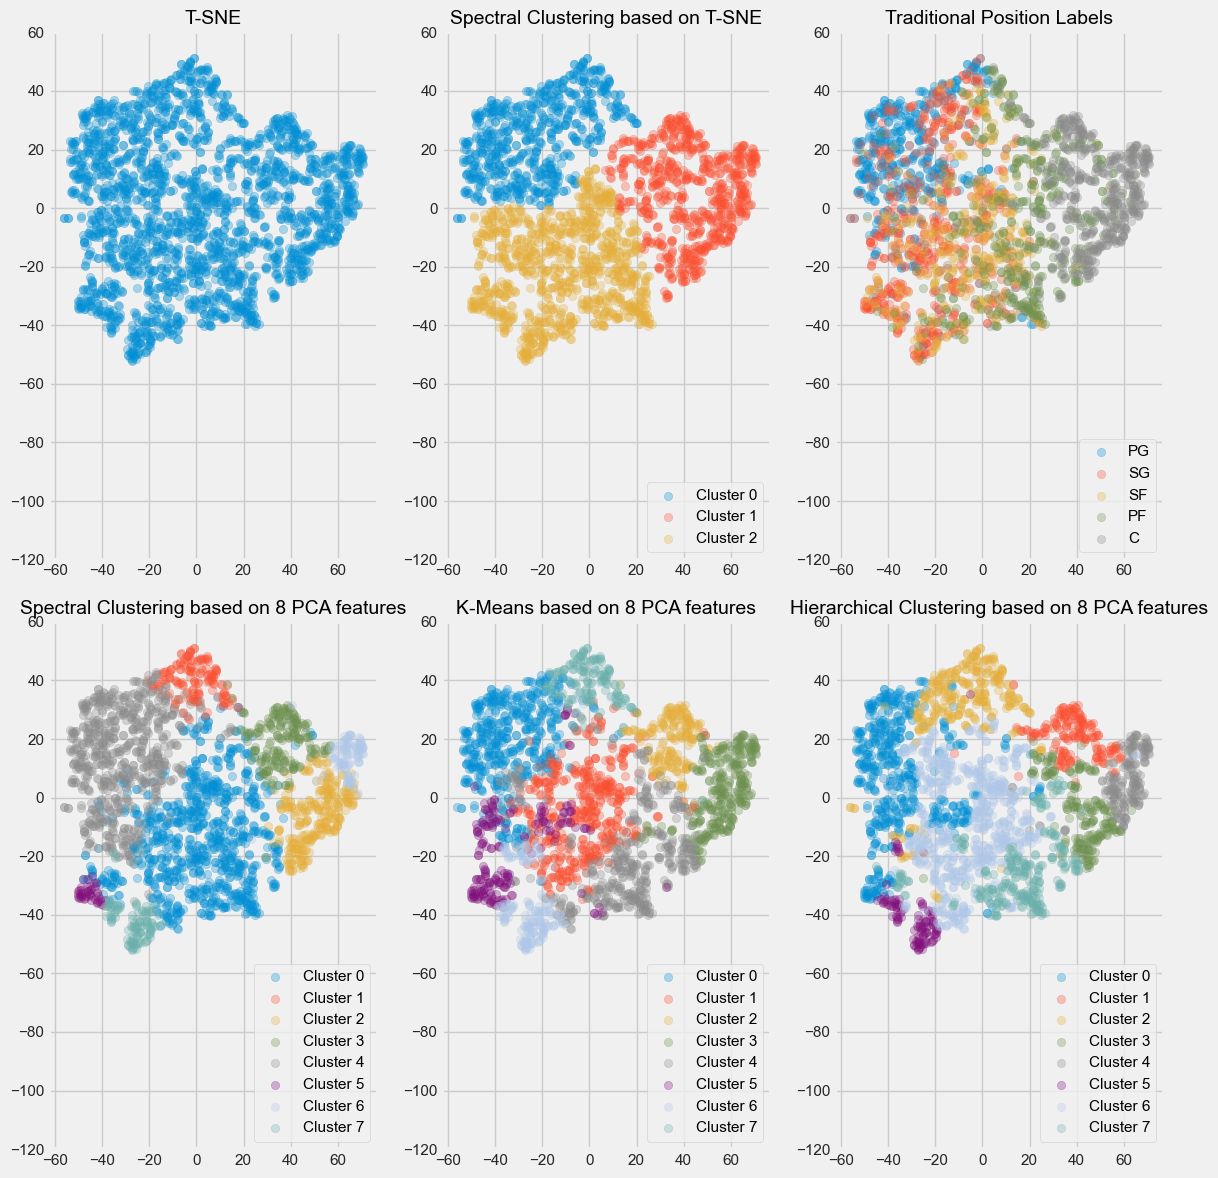

In [79]:
figsize(12, 12)

plt.subplot(2, 3, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title('T-SNE')
plt.ylim(lower_limit, upper_limit)

plt.subplot(2, 3, 2)
for i in range(n_clusters_tsne):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Spectral Clustering based on T-SNE')

plt.subplot(2, 3, 3)
for idx, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C'], 1):
    pos_cond = df['pos'] == pos
    pos_index = df[pos_cond].index
    plt.scatter(X_tsne[pos_index, 0], 
                X_tsne[pos_index, 1], 
                label=pos, 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Traditional Position Labels')

plt.subplot(2, 3, 4)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')

plt.subplot(2, 3, 5)
km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'K-Means based on {n_components} PCA features')

plt.subplot(2, 3, 6)
agc = AgglomerativeClustering(n_clusters=n_clusters, 
                              affinity='euclidean',
                              linkage='ward')
labels = agc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Hierarchical Clustering based on {n_components} PCA features')

plt.tight_layout()

Text(0.5, 1.0, 'Spectral Clustering based on 8 PCA features')

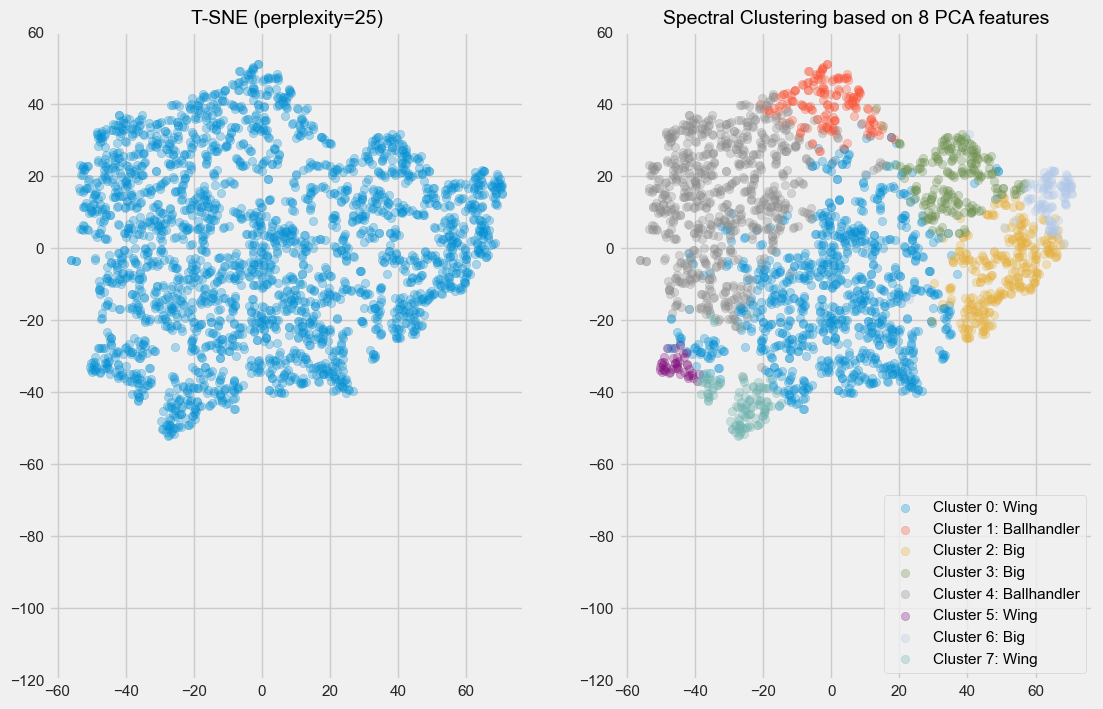

In [80]:
figsize(12, 8)

plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title(f'T-SNE (perplexity={perplexity})')
plt.ylim(lower_limit, upper_limit)

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')

Text(0.5, 1.0, 'Spectral Clustering based on 8 PCA features')

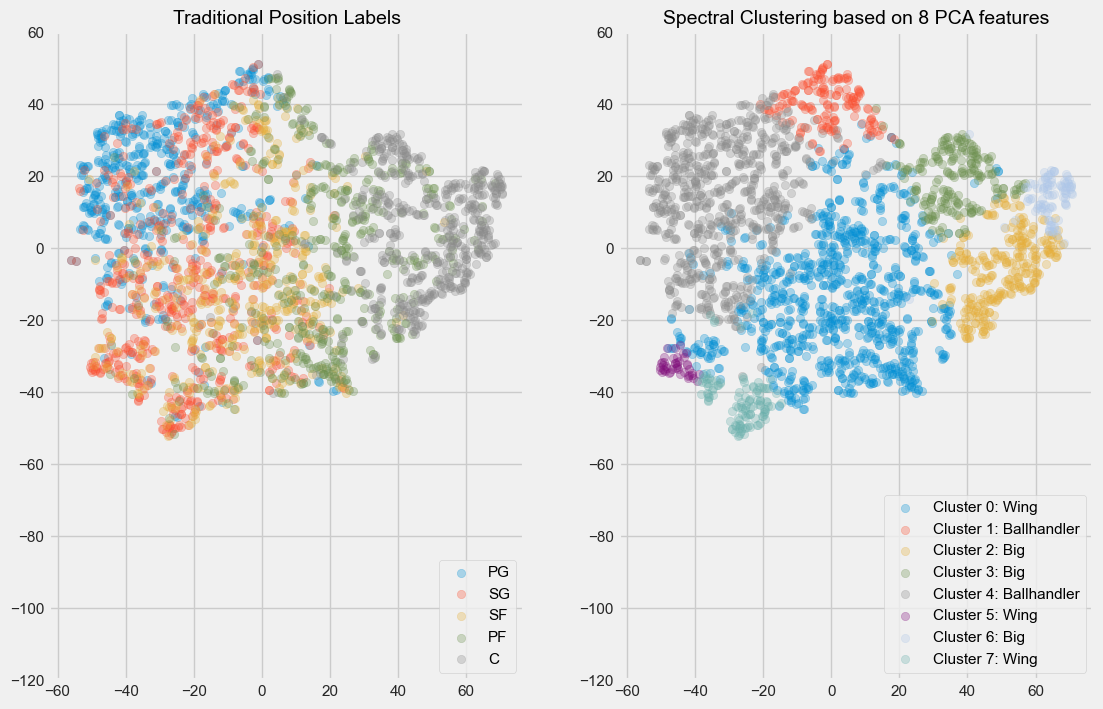

In [81]:
figsize(12, 8)

plt.subplot(1, 2, 1)
for idx, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C'], 1):
    pos_cond = df['pos'] == pos
    pos_index = df[pos_cond].index
    plt.scatter(X_tsne[pos_index, 0], 
                X_tsne[pos_index, 1], 
                label=pos, 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Traditional Position Labels')

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')

Text(0.5, 1.0, 'Spectral Clustering based on 8 PCA features\n[NBA]')

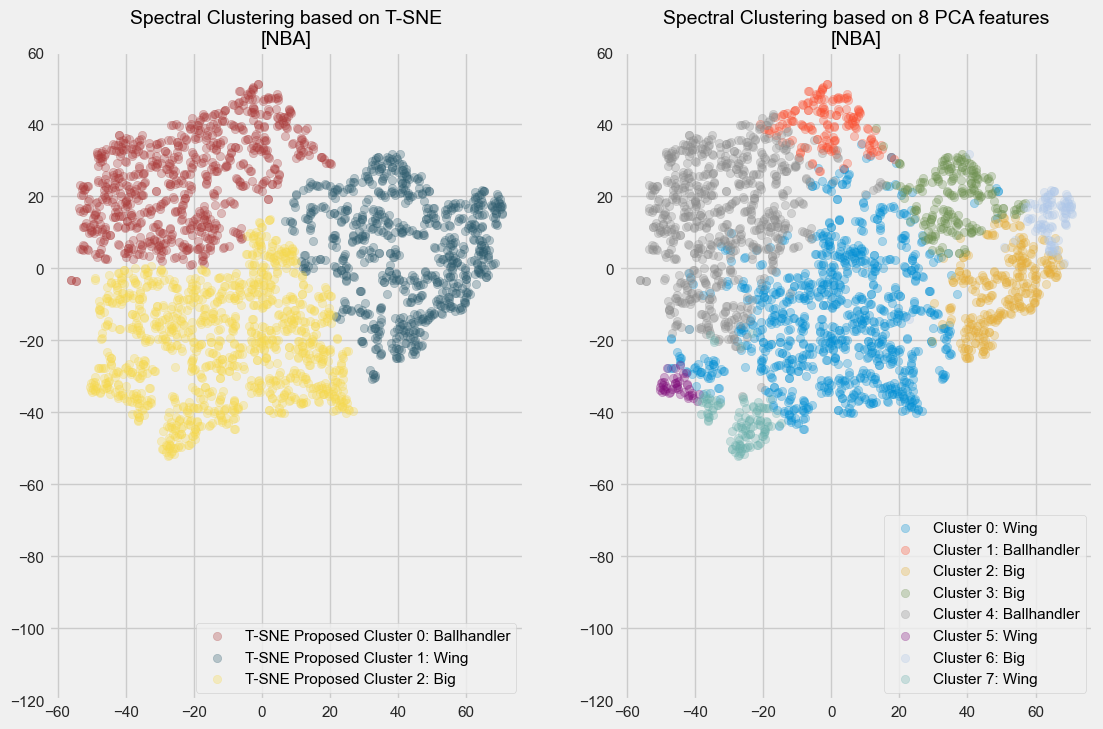

In [82]:
figsize(12, 8)

tsne_proposed_clusters = {0: 'Ballhandler',
                          1: 'Wing',
                          2: 'Big'}

plt.subplot(1, 2, 1)
for i in range(n_clusters_tsne):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'T-SNE Proposed Cluster {i}: {tsne_proposed_clusters[i]}', 
                color=color_cluster(i, tsne_proposed_clusters),
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Spectral Clustering based on T-SNE\n[NBA]')

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features\n[NBA]')

In [86]:
cluster_map_km_to_sc = {7: 1, 
                        4: 2, 
                        5: 5, 
                        1: 0, 
                        6: 7, 
                        0: 4, 
                        3: 6,
                        2: 3}

(-120.0, 60.0)

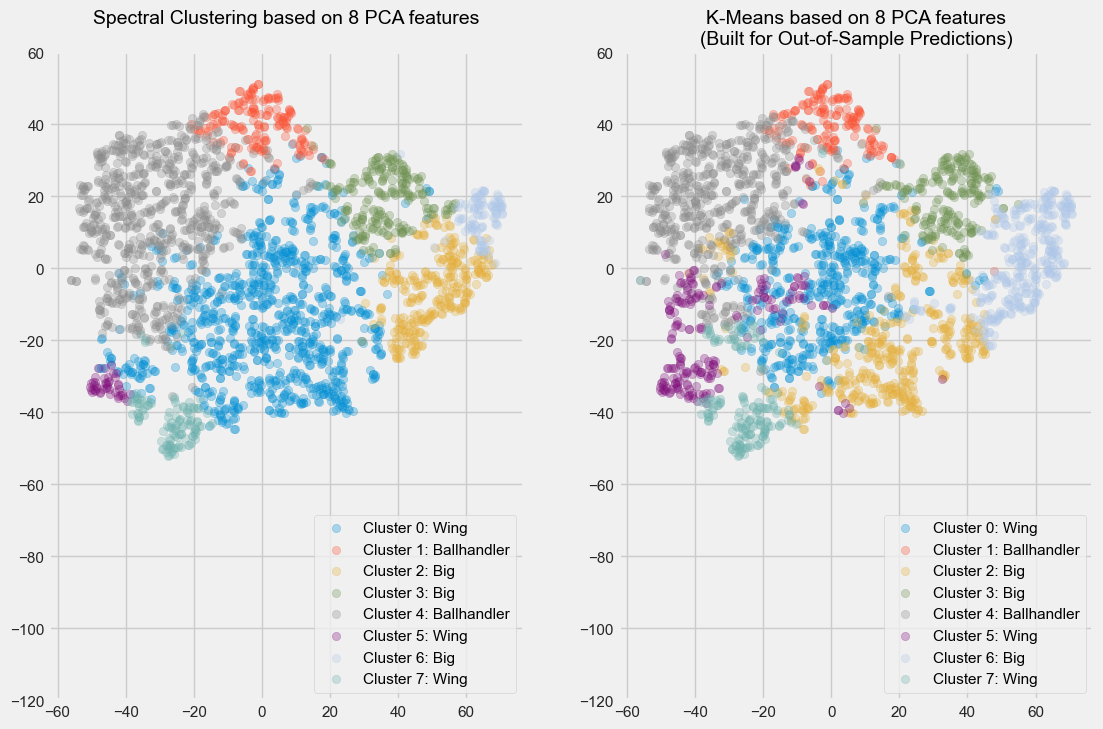

In [88]:
figsize(12, 8)

plt.subplot(1, 2, 1)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features\n')

plt.subplot(1, 2, 2)
km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(X_transformed)
labels = [cluster_map_km_to_sc[label] for label in labels]
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
oos = '(Built for Out-of-Sample Predictions)'
plt.title(f'K-Means based on {n_components} PCA features\n{oos}')
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)

## Save Models

In [89]:
df.to_csv('nba_cleaned.csv', index=False)

In [90]:
nba_clustering_models = {'pre_pca_pipe': pre_pca_pipe,
                         'pca': pca,
                         'pre_cluster_scaler': pre_cluster_scaler,
                         'cluster_dict': cluster_dict}
dump_pickle(nba_clustering_models, 'nba_clustering_models')

In [91]:
nba_clustering_models_km = {'pre_pca_pipe': pre_pca_pipe,
                            'pca': pca,
                            'pre_cluster_scaler': pre_cluster_scaler,
                            'cluster_map_to_spectral_clustering': cluster_map_km_to_sc,
                            'km': km}
dump_pickle(nba_clustering_models_km, 'nba_clustering_models_km')